In [23]:
import pandas as pd
import sys
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from utils.functions import plot_clusters_2d
from utils.functions import evaluate_clusters

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [24]:
def process_and_pivot(df, prefix):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna("Not Available", inplace=True)
    
    df_filtered = df[['Location', 'Period', 'Value']]
    df_pivoted = df_filtered.pivot(index='Location', columns='Period', values='Value')
    df_pivoted = df_pivoted.rename(columns=lambda x: f"{prefix}_{x}")
    
    return df_pivoted.reset_index()

advertisingBan = pd.read_csv('../data/advertising_ban_internet.csv')
affordability = pd.read_csv('../data/affordability.csv')
gdp2000Cigs = pd.read_csv('../data/gdp_for_2000_cigs.csv')
healthWarningPhoto = pd.read_csv('../data/health_warning_photo.csv')
requiredHealthWarnings = pd.read_csv('../data/required_health_warning.csv')

# Process and pivot each dataframe
advertisingBan_pivoted = process_and_pivot(advertisingBan, 'advertisingBan')
affordability_pivoted = process_and_pivot(affordability, 'affordability')
#ageStandardized_pivoted = process_and_pivot(ageStandardized, 'ageStandardized')
gdp2000Cigs_pivoted = process_and_pivot(gdp2000Cigs, 'gdp2000Cigs')
healthWarningPhoto_pivoted = process_and_pivot(healthWarningPhoto, 'healthWarningPhoto')
requiredHealthWarnings_pivoted = process_and_pivot(requiredHealthWarnings, 'requiredHealthWarnings')

# Merge the pivoted dataframes on 'Location'
combined_df = advertisingBan_pivoted.merge(affordability_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(gdp2000Cigs_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(healthWarningPhoto_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(requiredHealthWarnings_pivoted, on='Location', how='outer')
import warnings
warnings.filterwarnings('ignore')

In [25]:
data_for_clustering = combined_df.drop(columns=['Location'])

numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns

In [26]:
numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessing steps for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply the transformations to the data
X = preprocessor.fit_transform(data_for_clustering)

# Optionally, get feature names after encoding for better interpretability
# This requires scikit-learn version >= 1.0
try:
    encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(encoded_cat_features)
except:
    # For older versions of scikit-learn
    encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
    feature_names = numeric_features + list(encoded_cat_features)

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform hierarchical/agglomerative clustering using the linkage method
# 'ward' minimizes the variance within clusters and is generally a good default
linked = linkage(X, method='ward')  # You can also try 'complete', 'average', 'single'

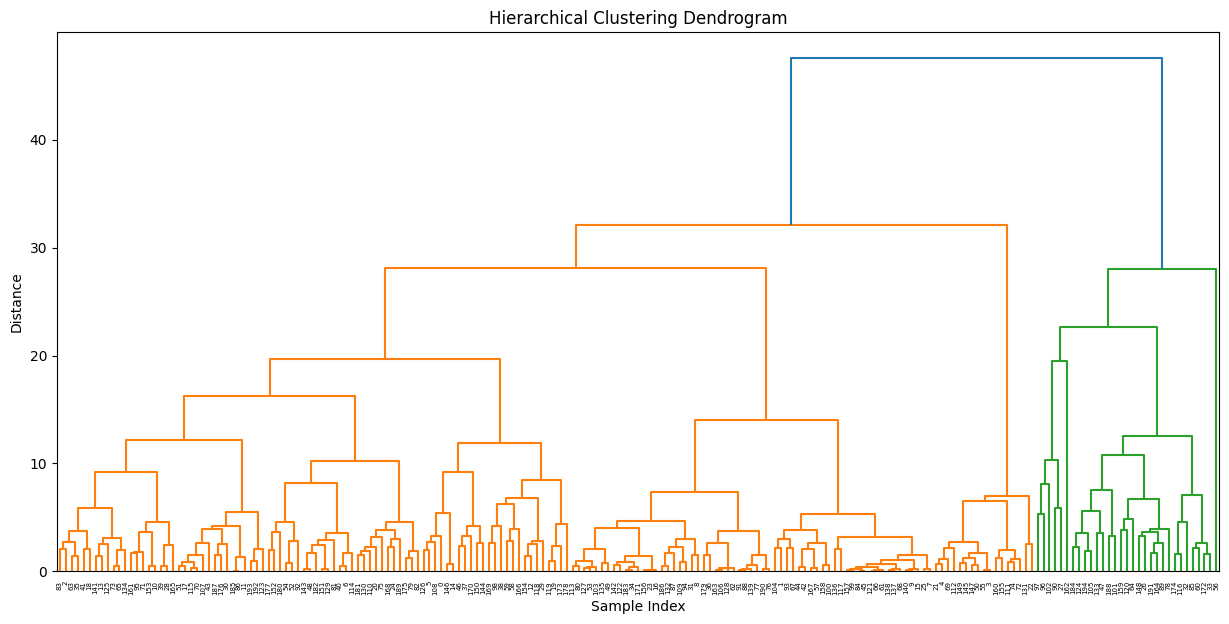

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [29]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
# Define the number of clusters, e.g., 3
n_clusters = 3

# Initialize the model
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

# Fit and predict cluster labels
cluster_labels = cluster.fit_predict(X)

# Add cluster labels to the original dataframe
combined_df['Cluster'] = cluster_labels

# Optional: Visualize clusters using pairplot (only feasible for a subset of features)
# Here, we'll select the first two numerical features for simplicity
if len(numeric_features) >= 2:
    sns.scatterplot(
        x=X[:, 0], 
        y=X[:, 1], 
        hue=cluster_labels, 
        palette='Set1'
    )
    plt.title('Clusters Visualization')
    plt.xlabel(numeric_features[0])
    plt.ylabel(numeric_features[1])
    plt.show()


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'